# Reorganize KL-CPD code

In [33]:
from typing import List, Tuple

import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torch

from optim import Optim

import mmd_util

## Dataloader

In [16]:
import os
import numpy as np
import scipy.io as sio
import math
import torch
from torch.autograd import Variable

class CustomDataLoader(object):
    def __init__(self, args, trn_ratio=0.6, val_ratio=0.8):
        self.device = args['device']
        #self.cuda = True
        self.data_path = args['data_path']
        self.p_wnd_dim = 25
        self.f_wnd_dim = args['wnd_dim']
        self.sub_dim = args['sub_dim']
        self.batch_size = args['batch_size']

        # load data
        self.load_data(trn_ratio=trn_ratio, val_ratio=val_ratio)

        # prepare data
        self.prepare_data()

        # split data into trn/val/tst set
        self.split_data()

    # load data
    def load_data(self, trn_ratio=0.6, val_ratio=0.8):
        assert(os.path.lexists(self.data_path))
        dataset = sio.loadmat(self.data_path)
        self.Y = dataset['Y']                                   # Y: time series data, time length x number of variables
        self.L = dataset['L']                                   # L: label of anomaly, time length x 1
        self.T, self.D = self.Y.shape                           # T: time length; D: variable dimension
        self.n_trn = int(np.ceil(self.T * trn_ratio))           # n_trn: first index of val set
        self.n_val = int(np.ceil(self.T * val_ratio))           # n_val: first index of tst set
        self.var_dim = self.D * self.sub_dim
        
        return dataset

    # prepare subspace data (Hankel matrix)
    def prepare_data(self):
        # T x D x sub_dim
        self.Y_subspace = np.zeros((self.T, self.D, self.sub_dim))
        for t in range(self.sub_dim, self.T):
            for d in range(self.D):
                self.Y_subspace[t, d, :] = self.Y[t - self.sub_dim + 1 : t + 1, d].flatten()

        # Y_subspace is now T x (D x sub_dim)
        self.Y_subspace = self.Y_subspace.reshape(self.T, -1)
        
        return self.Y_subspace

    # split data into trn/val/tst set
    def split_data(self):
        trn_set_idx = range(self.p_wnd_dim, self.n_trn)
        val_set_idx = range(self.n_trn, self.n_val)
        tst_set_idx = range(self.n_val, self.T)
        print('n_trn ', len(trn_set_idx), 'n_val ', len(val_set_idx), 'n_tst ', len(tst_set_idx))
        self.trn_set = self.__batchify(trn_set_idx)
        self.val_set = self.__batchify(val_set_idx)
        self.tst_set = self.__batchify(tst_set_idx)
        
        return self.trn_set, self.tst_set, self.val_set

    # convert augmented data in Hankel matrix to origin time series
    # input: X_f, whose shape is batch_size x seq_len x (D*sub_dim)
    # output: Y_t, whose shape is batch_size x D
    def repack_data(self, X_f, batch_size):
        Y_t = X_f[:, 0, :].contiguous().view(batch_size, self.D, self.sub_dim)
        return Y_t[:, :, -1]

    def __batchify(self, idx_set):
        n = len(idx_set)
        L = torch.zeros((n, 1))                             # anomaly label
        Y = torch.zeros((n, self.D))                        # true signal
        X_p = torch.zeros((n, self.p_wnd_dim, self.var_dim))  # past window buffer
        X_f = torch.zeros((n, self.f_wnd_dim, self.var_dim))  # future window buffer

        # XXX: dirty trick to augment the last buffer
        data = np.concatenate((self.Y_subspace, self.Y_subspace[-self.f_wnd_dim:, :]))
        for i in range(n):
            l = idx_set[i] - self.p_wnd_dim
            m = idx_set[i]
            u = idx_set[i] + self.f_wnd_dim
            X_p[i, :, :] = torch.from_numpy(data[l:m, :])
            X_f[i, :, :] = torch.from_numpy(data[m:u, :])
            Y[i, :] = torch.from_numpy(self.Y[m, :])
            L[i] = torch.from_numpy(self.L[m])
        return {'X_p': X_p, 'X_f': X_f, 'Y': Y, 'L': L}
    
    def get_dataloader(self, data_set, batch_size, shuffle=False):
        data = []
        X_p, X_f = data_set['X_p'], data_set['X_f']
        Y, L = data_set['Y'], data_set['L']
        length = len(Y)
        if shuffle:
            index = torch.randperm(length)
        else:
            index = torch.LongTensor(range(length))
        s_idx = 0
        while (s_idx < length):
            e_idx = min(length, s_idx + batch_size)
            excerpt = index[s_idx:e_idx]
            X_p_batch, X_f_batch = X_p[excerpt], X_f[excerpt]
            Y_batch, L_batch = Y[excerpt], L[excerpt]
            
            batch = [Variable(X_p_batch), 
                     Variable(X_f_batch), 
                     Variable(Y_batch), 
                     Variable(L_batch)]
            
            # не работает, оставил пока Variables
            #X_p_batch.requires_grad=True
            #X_f_batch.requires_grad=True
            #Y_batch.requires_grad=True
            #L_batch.requires_grad=True
            #batch = [X_p_batch, X_f_batch, Y_batch, L_batch]
            
            data.append(batch)
            #data.extend(batch)
            s_idx += batch_size
        
        return DataLoader(data)

## Define models

In [17]:
class NetG(nn.Module):
    def __init__(self, args, data, device) -> None:
            
        super(NetG, self).__init__()
        self.device = device
        self.wnd_dim = args['wnd_dim']
        self.var_dim = data.var_dim
        self.D = data.D
        self.RNN_hid_dim = args['RNN_hid_dim']

        self.rnn_enc_layer = nn.GRU(self.var_dim, self.RNN_hid_dim, num_layers=1, batch_first=True)
        self.rnn_dec_layer = nn.GRU(self.var_dim, self.RNN_hid_dim, num_layers=1, batch_first=True)
        self.fc_layer = nn.Linear(self.RNN_hid_dim, self.var_dim)

    # X_p:   batch_size x wnd_dim x var_dim (Encoder input)
    # X_f:   batch_size x wnd_dim x var_dim (Decoder input)
    # h_t:   1 x batch_size x RNN_hid_dim
    # noise: 1 x batch_size x RNN_hid_dim
    
    def forward(self, X_p, X_f, noise) -> torch.Tensor:
        
        X_p.to(self.device)
        X_f.to(self.device)
        
        X_p_enc, h_t = self.rnn_enc_layer(X_p)
        X_f_shft = self.shft_right_one(X_f)
        hidden = h_t + noise
        Y_f, _ = self.rnn_dec_layer(X_f_shft, hidden)
        output = self.fc_layer(Y_f).to(device)
        return output

    def shft_right_one(self, X) -> torch.Tensor:
        X_shft = X.clone()
        X_shft[:, 0, :].data.fill_(0)
        X_shft[:, 1:, :] = X[:, :-1, :]
        return X_shft

In [18]:
class NetD(nn.Module):
    def __init__(self, args, data, device) -> None:
        super(NetD, self).__init__()

        self.device = device
        self.wnd_dim = args['wnd_dim']
        self.var_dim = data.var_dim
        self.D = data.D
        self.RNN_hid_dim = args['RNN_hid_dim']

        self.rnn_enc_layer = nn.GRU(self.var_dim, self.RNN_hid_dim, batch_first=True)
        self.rnn_dec_layer = nn.GRU(self.RNN_hid_dim, self.var_dim, batch_first=True)

    def forward(self, X) -> Tuple[torch.Tensor, torch.Tensor]:
        
        X.to(self.device)
        X_enc, _ = self.rnn_enc_layer(X)
        X_dec, _ = self.rnn_dec_layer(X_enc)
        X_enc.to(device)
        X_dec.to(device)
        return X_enc, X_dec

## MMD Loss

In [19]:
def MMDLossD(X_f, 
             Y_f,
             X_f_enc,      # real (initial)   subseq (future window)
             Y_f_enc,      # fake (generated) subseq (future window)
             X_p_enc,      # real (initial)   subseq (past window)
             X_f_dec,
             Y_f_dec,
             lambda_ae,   
             lambda_real,
             sigma_var):
    
    # batchwise MMD2 loss between X_f and Y_f
    D_mmd2 = mmd_util.batch_mmd2_loss(X_f_enc, Y_f_enc, sigma_var)
    
    # batchwise MMD2 loss between X_p and X_f
    mmd2_real = mmd_util.batch_mmd2_loss(X_p_enc, X_f_enc, sigma_var)
    
    # reconstruction loss
    real_L2_loss = torch.mean((X_f - X_f_dec)**2)
    fake_L2_loss = torch.mean((Y_f - Y_f_dec)**2)
    
    lossD = D_mmd2.mean() - lambda_ae * (real_L2_loss + fake_L2_loss) - lambda_real * mmd2_real.mean()
    
    return lossD.mean()

In [ ]:
'''
MMDLossG: G_mmd2 = mmd_util.batch_mmd2_loss(X_f_enc, Y_f_enc, sigma_var)
          lossG = G_mmd2.mean()
'''

In [21]:
class KLCPD(pl.LightningModule):
    def __init__(
        self,
        netG: nn.Module,
        netD: nn.Module,
        args: dict
    ) -> None:
        super().__init__()
        
        self.args = args
        self.netG = netG
        self.netD = netD
        
        self.data = CustomDataLoader(args=args, trn_ratio=args['trn_ratio'], val_ratio=args['val_ratio'])
                
        sigma_list = mmd_util.median_heuristic(self.data.Y_subspace, beta=.5)
        self.sigma_var = torch.FloatTensor(sigma_list)
    
        
    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        X_p, X_f = inputs[0][0], inputs[1][0]

        batch_size = X_p.size(0)

        X_p_enc, _ = self.netD(X_p)
        X_f_enc, _ = self.netD(X_f)
        Y_pred = mmd_util.batch_mmd2_loss(X_p_enc, X_f_enc, self.sigma_var)
        
        return Y_pred
    
    def training_step(self, batch, batch_idx, optimizer_idx) -> torch.Tensor:
        
        # optimize discriminator (netD)
        if optimizer_idx == 1:
            
            X_p, X_f, Y_true = batch[0][0], batch[1][0], batch[2][0]  # Y_true is not used! -> for validation only

            batch_size = X_p.size(0)

            # real data
            X_p_enc, X_p_dec = self.netD(X_p)
            X_f_enc, X_f_dec = self.netD(X_f)

            # fake data
            noise = torch.FloatTensor(1, batch_size, args['RNN_hid_dim']).normal_(0, 1)
            noise = Variable(noise, volatile=True) # total freeze netG

            Y_f = Variable(self.netG(X_p, X_f, noise))
            Y_f_enc, Y_f_dec = self.netD(Y_f)
            
            lossD = (-1) * MMDLossD(X_f, Y_f, X_f_enc, Y_f_enc, X_p_enc, X_f_dec, Y_f_dec,
                                    self.args['lambda_ae'], self.args['lambda_real'], self.sigma_var)
            
            self.log("train_loss_D", lossD, on_step=True, prog_bar=True)

            return lossD
        
        # optimize generator (netG)
        if optimizer_idx == 0:

            X_p, X_f = batch[0][0], batch[1][0]
            batch_size = X_p.size(0)
            
            # real data
            X_f_enc, X_f_dec = self.netD(X_f)

            # fake data
            noise = torch.FloatTensor(1, batch_size, args['RNN_hid_dim']).normal_(0, 1)
            noise = Variable(noise)
            Y_f = self.netG(X_p, X_f, noise)
            Y_f_enc, Y_f_dec = self.netD(Y_f)

            # batchwise MMD2 loss between X_f and Y_f
            G_mmd2 = mmd_util.batch_mmd2_loss(X_f_enc, Y_f_enc, self.sigma_var)
            lossG = G_mmd2.mean()
            
            self.log("train_loss_G", lossG, on_step=True, prog_bar=True)
            
            return lossG
    '''
    def validation_step() -> torch.Tensor:
        
        return None
    '''
    def configure_optimizers(self) -> Tuple[torch.optim.Optimizer, torch.optim.Optimizer]:
        optimizerG = torch.optim.Adam(self.netG.parameters(), 
                                      lr=self.args['lr'], 
                                      #grad_clip=self.args['grad_clip'], 
                                      weight_decay=self.args['weight_decay'])
                                      #momentum=self.args['momentum'])
        
        optimizerD = torch.optim.Adam(netD.parameters(),
                                      lr=self.args['lr'],
                                      #grad_clip=self.args['grad_clip'],
                                      weight_decay=self.args['weight_decay'])
                                      #momentum=self.args['momentum'])
        
        return optimizerG, optimizerD
    
    def train_dataloader(self):
        return self.data.get_dataloader(data_set=self.data.trn_set,
                                        batch_size=self.args['batch_size'],
                                        shuffle=True)
    
    def val_dataloader(self):
        return self.data.get_dataloader(data_set=self.data.val_set,
                                        batch_size=self.args['batch_size'],
                                        shuffle=False)
    
    def test_dataloader(self):
        return self.data.get_dataloder(data_set=self.data.tst_set,
                                       batch_size=self.args['batch_size'],
                                       shuffle=False)

In [22]:
args = {}
args['data_path'] = '/home/eromanenkova/Intern_CPD/Alex/new_code/klcpd_code/data/beedance/beedance-1.mat'
args['trn_ratio'] = 0.6
args['val_ratio'] = 0.8
args['gpu'] = 0
#args['cuda'] = False
args['device'] = 'cpu'
args['random_seed'] = 1126
args['wnd_dim'] = 10
args['sub_dim'] = 1
args['RNN_hid_dim'] = 10
args['batch_size'] = 128
args['max_iter'] = 100
args['optim'] = 'adam'
args['lr'] = 3e-4
args['weight_decay'] = 0.
args['momentum'] = 0.
args['grad_clip'] = 10
args['eval_freq'] = 50
args['CRITIC_ITERS'] = 5
args['weight_clip'] = .1
args['lambda_ae'] = 0.001
args['lambda_real'] = 0.1
args['save_path'] = '/home/eromanenkova/Intern_CPD/Alex/new_code/klcpd_code/models'

In [7]:
device = args['device']
device

'cpu'

In [23]:
Data = CustomDataLoader(args=args, trn_ratio=args['trn_ratio'], val_ratio=args['val_ratio'])
netG = NetG(args, Data, device)
netD = NetD(args, Data, device)

n_trn  610 n_val  211 n_tst  211


In [24]:
kl_cpd_model = KLCPD(netG, netD, args)
kl_cpd_model

n_trn  610 n_val  211 n_tst  211


KLCPD(
  (netG): NetG(
    (rnn_enc_layer): GRU(3, 10, batch_first=True)
    (rnn_dec_layer): GRU(3, 10, batch_first=True)
    (fc_layer): Linear(in_features=10, out_features=3, bias=True)
  )
  (netD): NetD(
    (rnn_enc_layer): GRU(3, 10, batch_first=True)
    (rnn_dec_layer): GRU(10, 3, batch_first=True)
  )
)

In [26]:
'''
i = 0
for inputs in Data.get_batches(Data.tst_set, batch_size=128):
    print(i)
    #print('inputs:', inputs)
    #print('inputs, X_p:', inputs[0])
    print('X_p size', inputs[0].size())
    #print('inputs, X_f:', inputs[1])
    print('X_f size', inputs[1].size())

    print('preds: ', kl_cpd_model(inputs))
    print('preds size: ', kl_cpd_model(inputs).size())
    print('-------------------------')
    i += 1
'''

"\ni = 0\nfor inputs in Data.get_batches(Data.tst_set, batch_size=128):\n    print(i)\n    #print('inputs:', inputs)\n    #print('inputs, X_p:', inputs[0])\n    print('X_p size', inputs[0].size())\n    #print('inputs, X_f:', inputs[1])\n    print('X_f size', inputs[1].size())\n\n    print('preds: ', kl_cpd_model(inputs))\n    print('preds size: ', kl_cpd_model(inputs).size())\n    print('-------------------------')\n    i += 1\n"

In [37]:
tst_dataloader = Data.get_dataloader(Data.tst_set, batch_size=128)
i = 0
for inputs in tst_dataloader:
    print(i)
    #print('inputs:', inputs)
    #print('inputs size:')
    print('inputs, X_p:', inputs[0])
    print('X_p size', inputs[0].size())
    print('inputs, X_f:', inputs[1])
    print('X_f size', inputs[1].size())
    print('preds: ', kl_cpd_model(inputs))
    print('-------------------------')
    i += 1

0
inputs, X_p: tensor([[[[0.0329, 0.5202, 0.5342],
          [0.0110, 0.5202, 0.7105],
          [0.0000, 0.5305, 0.4355],
          ...,
          [0.1834, 0.5573, 0.4651],
          [0.1678, 0.5144, 0.5982],
          [0.1956, 0.5608, 0.3587]],

         [[0.0110, 0.5202, 0.7105],
          [0.0000, 0.5305, 0.4355],
          [0.0110, 0.5614, 0.4302],
          ...,
          [0.1678, 0.5144, 0.5982],
          [0.1956, 0.5608, 0.3587],
          [0.2039, 0.5170, 0.6962]],

         [[0.0000, 0.5305, 0.4355],
          [0.0110, 0.5614, 0.4302],
          [0.0329, 0.5614, 0.5269],
          ...,
          [0.1956, 0.5608, 0.3587],
          [0.2039, 0.5170, 0.6962],
          [0.2126, 0.5173, 0.5163]],

         ...,

         [[0.3805, 0.7468, 0.5543],
          [0.3711, 0.7085, 0.5416],
          [0.3473, 0.6946, 0.4791],
          ...,
          [0.5100, 0.6877, 0.4941],
          [0.5099, 0.7374, 0.5985],
          [0.5045, 0.6968, 0.7804]],

         [[0.3711, 0.7085, 0.5416],
  

/home/eromanenkova/Intern_CPD/Alex/new_code/klcpd_code/mmd_util.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sigma_samples = F.softmax(U * gumbel_lmd).matmul(sigma_var)


preds:  tensor([1.0064, 0.9044, 0.8421, 0.8269, 0.7617, 0.7362, 0.7478, 0.7158, 0.7594,
        0.7479, 0.7760, 0.7825, 0.7785, 0.8150, 0.8603, 0.8499, 0.8856, 0.9783,
        0.9578, 0.9728, 1.0343, 1.0389, 0.9958, 1.0200, 0.9461, 0.9718, 0.9863,
        0.9984, 1.0495, 1.0560, 1.1592, 1.1732, 1.3867, 1.3764, 1.3999, 1.4027,
        1.5239, 1.5906, 1.5749, 1.6259, 1.6717, 1.5852, 1.5570, 1.5133, 1.3878,
        1.3377, 1.3158, 1.2272, 1.1697, 1.0368, 0.8910, 0.8285, 0.7763, 0.7351,
        0.6426, 0.6119, 0.5494, 0.5377, 0.5526, 0.5624, 0.6294, 0.6962, 0.8196,
        1.0219, 1.1108, 1.2353, 1.3677, 1.4300, 1.4236, 1.4306, 1.4406, 1.5324,
        1.5173, 1.5500, 1.6200, 1.6691, 1.6294, 1.6819, 1.6444, 1.5413, 1.6238,
        1.5449, 1.5747, 1.6442, 1.7012, 1.6466, 1.7600, 1.7154, 1.7155, 1.5969,
        1.6107, 1.4532, 1.3719, 1.3200, 1.1798, 1.1351, 1.0369, 1.0821, 1.0282,
        1.0067, 0.8983, 0.9435, 0.9222, 0.8765, 0.8531, 0.8069, 0.8042, 0.7782,
        0.7517, 0.7723, 0.7587, 

In [25]:
# Y, L should be numpy array
def valid_epoch(loader, data, kl_cpd_model, batch_size, Y_true, L_true):
    #netD.eval()
    Y_pred = []
    for inputs in loader.get_dataloader(data, batch_size, shuffle=False):
        X_p, X_f = inputs[0][0], inputs[1][0]
        
        batch_size = X_p.size(0)

        X_p_enc, _ = kl_cpd_model.netD(X_p)
        X_f_enc, _ = kl_cpd_model.netD(X_f)
        Y_pred_batch = mmd_util.batch_mmd2_loss(X_p_enc, X_f_enc, sigma_var)
        Y_pred.append(Y_pred_batch.data.cpu().numpy())
    Y_pred = np.concatenate(Y_pred, axis=0)

    L_pred = Y_pred
    #fp_list, tp_list, thresholds = sklearn.metrics.roc_curve(L_true, L_pred)
    #auc = sklearn.metrics.auc(fp_list, tp_list)
    #eval_dict = {'Y_pred': Y_pred,
    #             'L_pred': L_pred,
    #             'Y_true': Y_true,
    #             'L_true': L_true,
    #             'mse': -1, 'mae': -1, 'auc': auc}
    #netD.train()
    return Y_pred

In [26]:
Y_tst = Data.tst_set['Y'].numpy()
L_tst = Data.tst_set['L'].numpy()
sigma_list = mmd_util.median_heuristic(Data.Y_subspace, beta=.5)
sigma_var = torch.FloatTensor(sigma_list)
print('sigma_var:', sigma_var)

sigma_var: tensor([0.0397, 0.0795, 0.1589, 0.3179, 0.6357])


### Before training

In [27]:
pred = valid_epoch(Data, Data.val_set, kl_cpd_model, args['batch_size'], Y_tst, L_tst)
pred = pred / np.max(pred)
pred

/home/eromanenkova/Intern_CPD/Alex/new_code/klcpd_code/mmd_util.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sigma_samples = F.softmax(U * gumbel_lmd).matmul(sigma_var)


array([0.29819736, 0.31684113, 0.3127071 , 0.3215282 , 0.33419958,
       0.3582331 , 0.4005285 , 0.45032898, 0.5213737 , 0.52993226,
       0.5588394 , 0.5415831 , 0.4876119 , 0.4571652 , 0.39258295,
       0.36684233, 0.34979114, 0.34087414, 0.34133163, 0.34298944,
       0.33409467, 0.33718818, 0.37093273, 0.42554256, 0.45834985,
       0.4909198 , 0.5010994 , 0.5068238 , 0.5588223 , 0.57267964,
       0.636568  , 0.64831454, 0.6826857 , 0.75308764, 0.7968967 ,
       0.8373317 , 0.84835404, 0.92113227, 0.9308309 , 0.91975623,
       0.92893374, 0.9235667 , 0.86326444, 0.85431015, 0.8490353 ,
       0.79084224, 0.812289  , 0.8396985 , 0.8191958 , 0.7867148 ,
       0.7710637 , 0.7718181 , 0.801338  , 0.7868718 , 0.81422323,
       0.78938586, 0.74445444, 0.7722635 , 0.7284348 , 0.7032675 ,
       0.7356901 , 0.7339393 , 0.809821  , 0.792623  , 0.830251  ,
       0.846633  , 0.89843756, 0.93190366, 0.87667   , 0.9237601 ,
       0.89349014, 0.87659377, 0.8616799 , 0.7900424 , 0.79694

In [28]:
true = L_tst.flatten()
#true

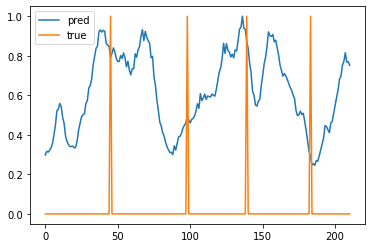

In [29]:
plt.figure()
plt.plot(pred, label='pred')
plt.plot(true, label='true')
plt.legend()

In [30]:
logger = TensorBoardLogger(save_dir='logs/', name='experiments_beedance1_equal_weights')

In [31]:
trainer = pl.Trainer(
        max_epochs=10,
        gpus=0,
        benchmark=True,
        #check_val_every_n_epoch=1,
        #gradient_clip_val=gradient_clip_val,
        logger=logger
        #callbacks=callbacks
)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  warnings.warn(*args, **kwargs)


In [32]:
trainer.fit(kl_cpd_model)

/home/eromanenkova/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  warnings.warn(*args, **kwargs)

  | Name | Type | Params
------------------------------
0 | netG | NetG | 933   
1 | netD | NetD | 585   
------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

/home/eromanenkova/Intern_CPD/Alex/new_code/klcpd_code/mmd_util.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  sigma_samples = F.softmax(U * gumbel_lmd).matmul(sigma_var)
/home/eromanenkova/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


RuntimeError: Trying to backward through the graph a second time, but the saved intermediate results have already been freed. Specify retain_graph=True when calling .backward() or autograd.grad() the first time.

In [52]:
%reload_ext tensorboard
%tensorboard --logdir 'logs' --port 5555

Reusing TensorBoard on port 5555 (pid 19392), started 5:11:21 ago. (Use '!kill 19392' to kill it.)

### After training

In [66]:
pred_trained = valid_epoch(Data, Data.val_set, kl_cpd_model, args['batch_size'], Y_tst, L_tst)
pred_trained = pred_trained / np.max(pred_trained)

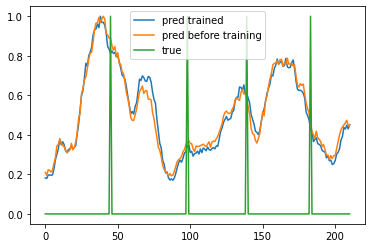

In [67]:
plt.figure()
plt.plot(pred_trained, label='pred trained')
plt.plot(pred, label='pred before training')
plt.plot(true, label='true')
plt.legend()